# Mock for Song

## Notes

We work in distances of **Mpc/h** and masses of **Msun**.

## Import etc...

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate, scipy.optimize
import emcee

import data as d
import likelihood as l
import plots as p
import clustering as c


from get_sm_for_sim import get_sm_for_sim, get_smf

from Corrfunc.utils import convert_3d_counts_to_cf

%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [4]:
sim_data, sim_size = d.load_mdpl()
obs_smf = d.load_smf()
gals = d.load_hsc_gals()

In [11]:
useMass = True
if useMass:
    # Starting params from https://redwoodforest.slack.com/files/U5WT8PBKN/FDD17SXN0/image.png 
    #params = [10**12.52, 10**10.91, 0.45, 0.6, 1.83] # m1, sm0, beta, delta, gamma
    b_params = [12.52, 10.91, 0.45, 0.6, 1.83] # Fix beta and gamma
    s_params = [-0.06, 1.08]

    # Bestfir from MDPL without clustering
    best_fit = [12.46178498, 10.87987102,  0.45690214,  0.636816,    1.87057079, -0.0614553,   1.07878507]
    
    x_field = "halo_mvir" # Note that for Mdpl this is mpeak
else:
    # Best when I think I have the wrong mpc/h fix
    b_params = [ 2.44660736e-01,  9.61282490e+00,  7.76096468e-03,  2.62252235e-01,  1.03957873e+01]
    s_params = [1.06094865e-02, -2.35296184e-02]
    
    x_field = "Vmax@Mpeak"

#b_params_v = [0.118, 9.81, 0.45, 0.237, 1.83]
#s_params_v = [0.20, 0]

## Sanity check data

16.122023699246338 15.625


[None]

/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


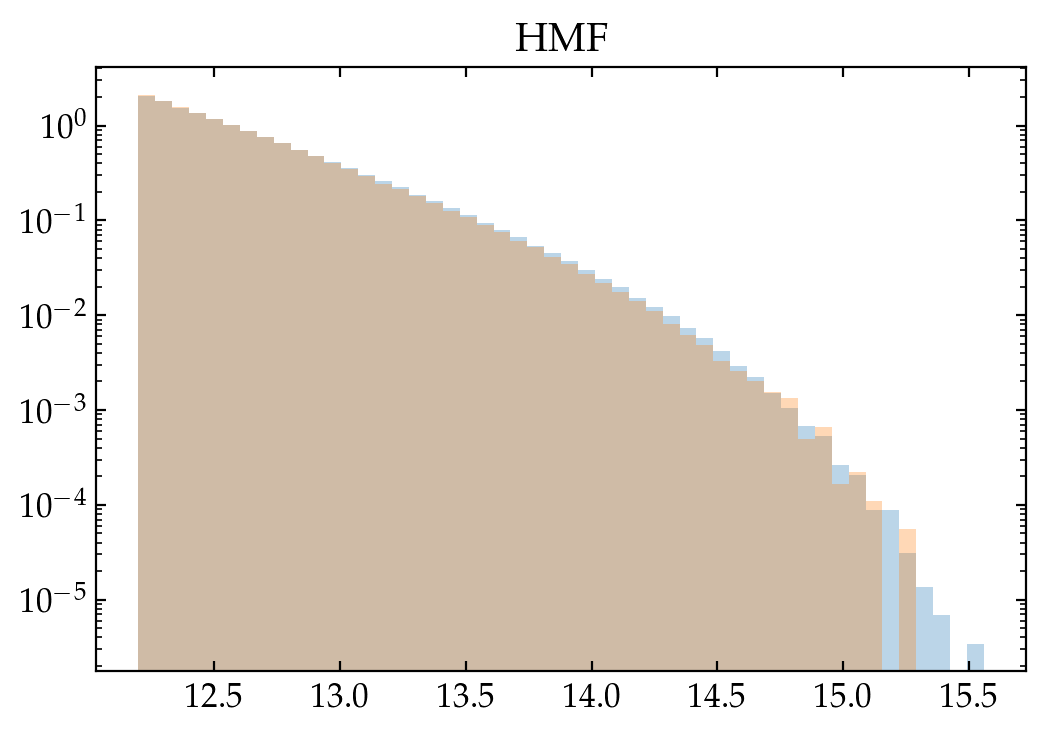

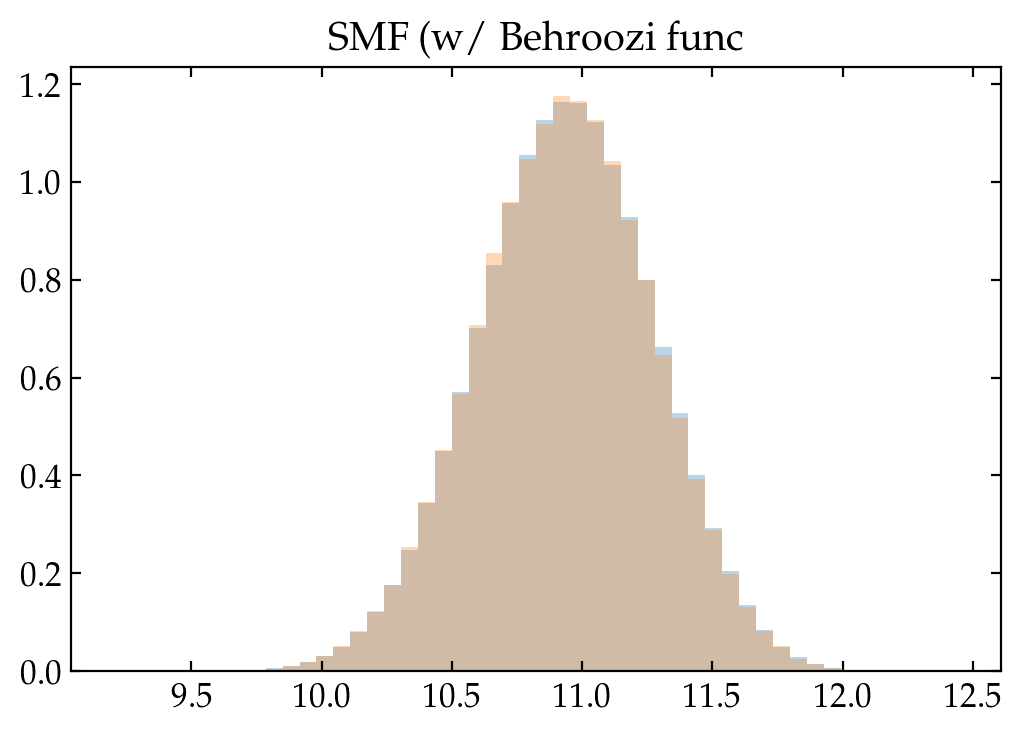

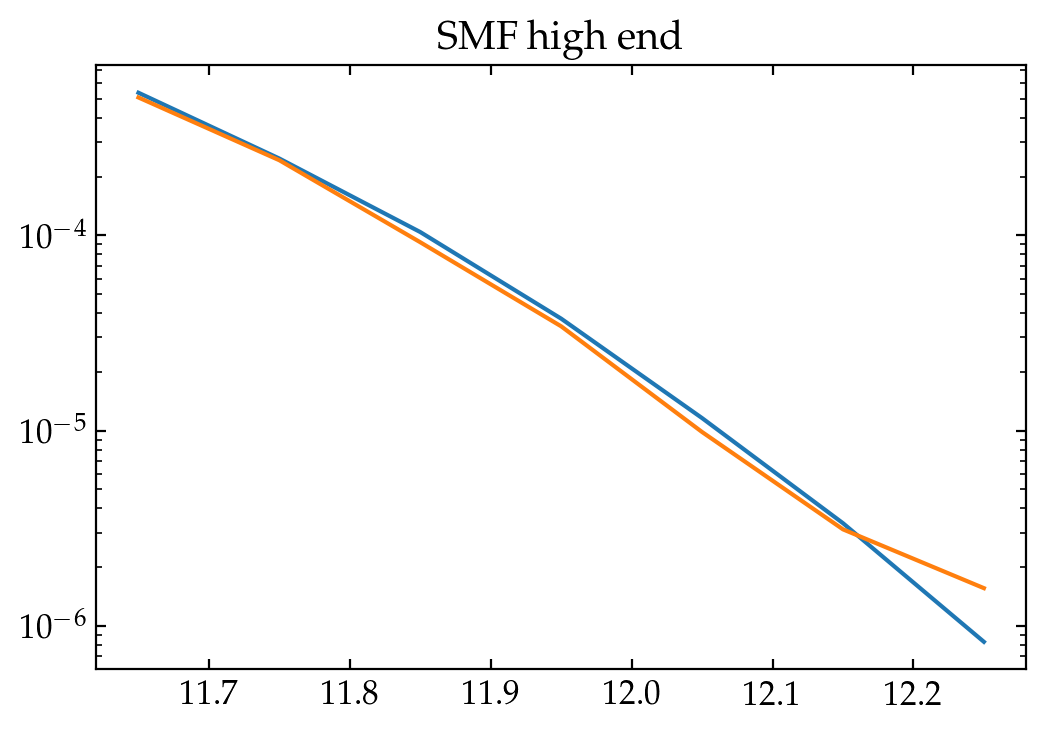

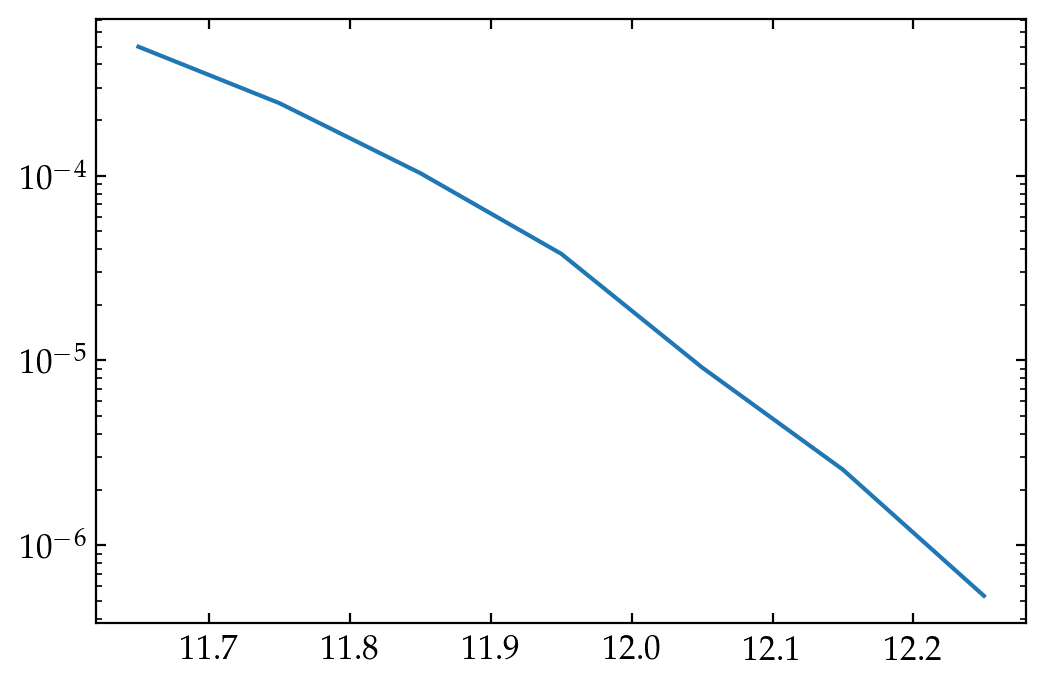

In [55]:
# Halo masses should be similar in smdpl and mdpl
mdpl, mdpl_size = d.load_mdpl()
smdpl, smdpl_size = d.load_smdpl()

_, ax = plt.subplots()
_, bins, _ = ax.hist(np.log10(mdpl["halo_mvir"]), bins=50, density=True, alpha=0.3)
ax.hist(np.log10(smdpl["halo_mvir"]), bins=bins, density=True, alpha=0.3)
ax.set(yscale="log", title="HMF")

# Stellar masses should be similar
mdpl_sm = get_sm_for_sim(mdpl, b_params, s_params)
smdpl_sm = get_sm_for_sim(smdpl, b_params, s_params)

_, ax = plt.subplots()
_, bins, _ = ax.hist(mdpl_sm, bins=50, density=True, alpha=0.3)
ax.hist(smdpl_sm, bins=bins, density=True, alpha=0.3)
ax.set(title="SMF (w/ Behroozi func)")

# The SMF should be similar
sm_bins = np.linspace(11.6, 12.3, 8)
sm_bin_centers = (sm_bins[:-1] + sm_bins[1:]) / 2

_, ax = plt.subplots()
ax.plot(sm_bin_centers, get_smf(mdpl_sm, sm_bins, mdpl_size**3))
ax.plot(sm_bin_centers, get_smf(smdpl_sm, sm_bins, smdpl_size**3))
ax.set(yscale="log", title="SMF high end")

# The ratio of the number of galaxies should be similar to the ratio of volumes
print(len(mdpl) / len(smdpl), mdpl_size**3 / smdpl_size**3)

# Smf should be quite a bit larger than 1e-4 at 11.6 (different to fig 4 https://arxiv.org/pdf/1707.01904.pdf)
_, ax = plt.subplots()
plt.plot(obs_smf["logm_mean"], obs_smf["smf"])
ax.set(yscale="log")

# Go from mass to Vmax

Per peter, Mpeak has too low clustering. We should instead be using Vmax at Mpeak. However we have no idea what the start point for Vmax@Mpeak should be...

Use the start point for mpeak find the stellar masses. Then work out the best fit to those stellar masses with Mpeak using the same function. And now you have your starting params!

/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/christopher/research/satellite_fraction/cb/smhm_fit/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


'\ndef diff(p, sim_data):\n    print(p)\n    try:\n        _, _, pred_sm, _, _, _ = get_sm_for_sim(sim_data, p[:5], p[5:], "Vmax@Mpeak", sanity=True)\n    except ValueError:\n        return 1e10\n    err = np.sum(np.power(sample_sm - pred_sm, 2))\n    print(err)\n    return err\n\nres = scipy.optimize.minimize(\n    diff,\n    b_params_v + s_params_v,\n    args=(sim_data),\n    method="Nelder-Mead",\n)\n'

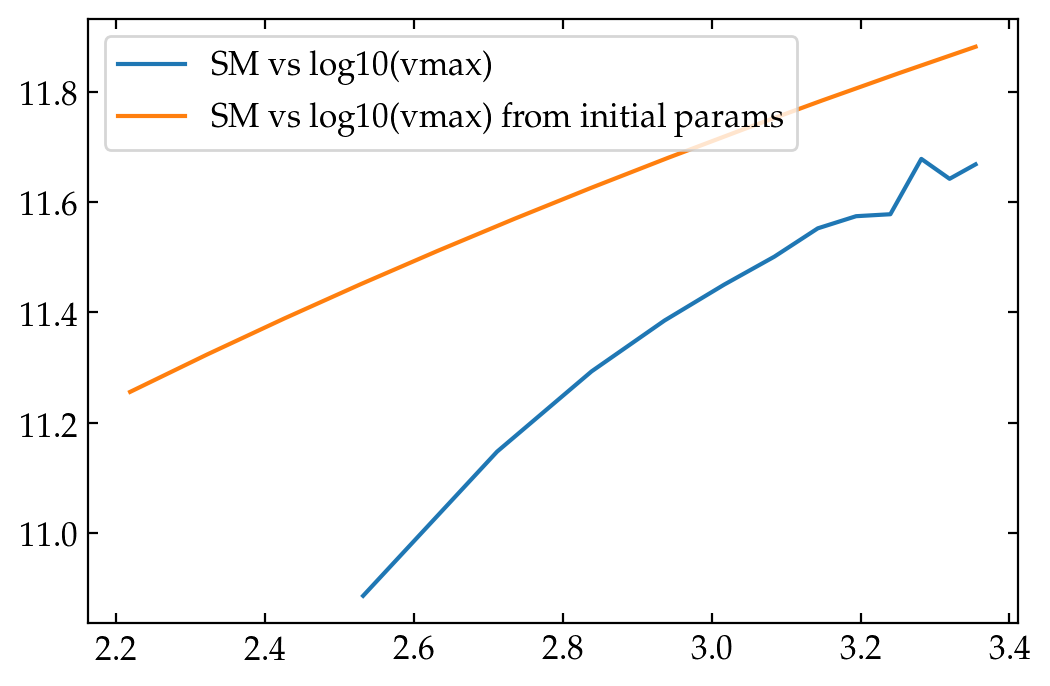

In [123]:
_, ax = plt.subplots()

# First just get the stellar masses
log_stellar_masses, sample_halo, sample_stellar, _, _, _ = get_sm_for_sim(sim_data, b_params, s_params, "halo_mvir", sanity=True)
#ax.plot(sample_halo, sample_stellar)

# Now bin those stellar masses by Vmax@Mpeak. We now have Vmax -> Stellar mass relation
sample_sm, bin_edges, _ = scipy.stats.binned_statistic(sim_data["Vmax@Mpeak"], log_stellar_masses, bins = 12)
sample_vmax = bin_edges[:-1] + np.diff(bin_edges)[0]

ax.plot(np.log10(sample_vmax), sample_sm, label="SM vs log10(vmax)")

# We want to find the 5 params + 2 scatter params that fit this vmax -> sm relation


log_stellar_masses, sample_vmax, sample_stellar, _, _, _ = get_sm_for_sim(sim_data, best_p[:5], best_p[5:] + np.array([1.5, 0]), "Vmax@Mpeak", sanity=True)
ax.plot(sample_vmax, sample_stellar, label="SM vs log10(vmax) from initial params")
ax.legend()
"""
_, ax = plt.subplots()
ax.hist(log_stellar_masses[log_stellar_masses > 11.6])
"""
"""
def diff(p, sim_data):
    print(p)
    try:
        _, _, pred_sm, _, _, _ = get_sm_for_sim(sim_data, p[:5], p[5:], "Vmax@Mpeak", sanity=True)
    except ValueError:
        return 1e10
    err = np.sum(np.power(sample_sm - pred_sm, 2))
    print(err)
    return err

res = scipy.optimize.minimize(
    diff,
    b_params_v + s_params_v,
    args=(sim_data),
    method="Nelder-Mead",
)
"""

# Find bestfit to SMF with optimizer

In [6]:
cen_cuts = (11.65, 12.5)
sat_cuts = (11.55, 11.65)

obs_clust, _ = c.compute_hsc_clustering(gals, cen_cuts, sat_cuts)

Randoms should be much longer that sample: 500000 1565 1708


/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/Corrfunc/mocks/DDrppi_mocks.py:348: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warn('One or more input array has non-native endianness!  A copy will be made with the correct endianness.')


In [10]:
params = b_params + s_params

res = scipy.optimize.minimize(
    l.compute_chi2_n,
    x0 = params,
    args=(sim_data, obs_smf, obs_clust, sim_size, cen_cuts, sat_cuts, x_field, 1),
    method="Nelder-Mead",
    tol=1,
)
assert res.success == True
best_fit = res.x

[12.4506438  10.88120647  0.45        0.64241464  1.83       -0.0612849   1.07830828]
4.198188974778059
[13.07317599 10.88120647  0.45        0.64241464  1.83       -0.0612849   1.07830828]
330.76101041705545
[12.4506438  11.42526679  0.45        0.64241464  1.83       -0.0612849   1.07830828]
651755.5669945604
[12.4506438  10.88120647  0.4725      0.64241464  1.83       -0.0612849   1.07830828]
2.931032438530431
[12.4506438  10.88120647  0.45        0.67453537  1.83       -0.0612849   1.07830828]
1.7529638905426903
[12.4506438  10.88120647  0.45        0.64241464  1.9215     -0.0612849   1.07830828]
2.675403507218223
[12.4506438  10.88120647  0.45        0.64241464  1.83       -0.06434915  1.07830828]
104.59885021961304
[12.4506438  10.88120647  0.45        0.64241464  1.83       -0.0612849   1.13222369]
899.2983996450661
[12.62851014 10.33714615  0.45642857  0.65159199  1.85614286 -0.0621604   1.09371268]
415.982527948418
[12.67932909 10.72576066  0.45826531  0.65421409  1.86361224 -

1.9344902658117773
[12.4581918  10.88035927  0.45558165  0.64778472  1.85348395 -0.06148849  1.07869599]
1.3579178181783667
[12.46233716 10.87807457  0.45836444  0.63791703  1.85132451 -0.0614671   1.0782234 ]
1.5765358362301567
[12.46529097 10.87917001  0.46049047  0.63757086  1.88406779 -0.06153145  1.0788834 ]
1.7144970451896444
[12.45742673 10.87983437  0.4549329   0.64450182  1.85291208 -0.06139229  1.07842496]
1.245091439208975
[12.46526855 10.87951505  0.46056093  0.63848271  1.83591565 -0.06156481  1.0790264 ]
1.6927402623768057
[12.4578711  10.87968245  0.45521816  0.64381281  1.87069366 -0.0613889   1.07840276]
1.4902669293497715
[12.45706066 10.88163812  0.45473479  0.64783971  1.87241152 -0.06140563  1.07904912]
1.499534993113203
[12.45837978 10.88074723  0.45564221  0.64535904  1.86713977 -0.061421    1.07884269]
1.2591639108132078
[12.46167205 10.88033447  0.45800223  0.64238571  1.85202697 -0.061493    1.07899546]
1.4254352203134413
[12.46072182 10.88017146  0.45730621  

1.586897396212128
[12.46178367 10.87989613  0.45690794  0.63689191  1.87031541 -0.06145486  1.07878785]
1.2800611064200365
[12.46178006 10.87987656  0.45677681  0.63700382  1.87032527 -0.06145436  1.07878243]
1.257691025327837
[12.46190927 10.87986931  0.45682753  0.63679913  1.87069213 -0.06145696  1.07879249]
1.2638834827553025
[12.46187653 10.87988942  0.45686991  0.63669248  1.8709426  -0.06145575  1.07879157]
1.6389785756290622
[12.4618282  10.87987055  0.45681857  0.63688895  1.87060111 -0.06145452  1.07878722]
1.2418243156578077
[12.46176325 10.87986134  0.45683381  0.6370229   1.87010225 -0.06145455  1.07878148]
1.4453362257635085
[12.46176677 10.8798784   0.45682171  0.63699457  1.87028908 -0.06145489  1.0787848 ]
1.288811208132433
[12.46180021 10.87987536  0.4568237   0.63701744  1.87028572 -0.06145531  1.07878793]
1.1595748365174001
[12.46185194 10.87989219  0.45684574  0.63680905  1.87077761 -0.06145579  1.07879217]
1.4709281210536072
[12.46178542 10.87986905  0.45683679  0

1.3809295866712283
[12.46178529 10.87987124  0.45690229  0.63681682  1.87056897 -0.0614553   1.07878512]
1.6515000818090642
[12.46178533 10.87987137  0.45690221  0.63681642  1.87056806 -0.06145529  1.0787851 ]
1.290217428589059
[12.46178479 10.87987097  0.45689839  0.63682201  1.8705634  -0.06145527  1.07878498]
1.6566202469331266
[12.46178549 10.87987145  0.45690352  0.63681472  1.87056997 -0.0614553   1.07878515]
1.0464448817737115
[12.46178589 10.87987109  0.45690139  0.63681687  1.87056837 -0.0614553   1.0787851 ]
1.3835992386632319
[12.46178509 10.87987139  0.45690223  0.63681683  1.87056794 -0.06145529  1.0787851 ]
1.2567791807859852
[12.46178532 10.87987125  0.45690343  0.63681339  1.87057323 -0.06145529  1.07878507]
1.1223263509825523
[12.46178531 10.87987118  0.45690243  0.63681563  1.87057071 -0.06145529  1.07878508]
1.372973299403575
[12.46178533 10.87987132  0.45690227  0.63681623  1.87056872 -0.06145529  1.0787851 ]
1.335976160695361
[12.46178524 10.87987124  0.45690283  0

1.1352573446940317
[12.46178499 10.87987103  0.45690212  0.63681604  1.87057076 -0.0614553   1.07878507]
1.3359686812308935
[12.46178498 10.87987103  0.45690214  0.63681603  1.87057075 -0.0614553   1.07878507]
1.2805519560214944
[12.46178503 10.87987103  0.45690216  0.63681593  1.87057095 -0.0614553   1.07878507]
1.362137892439697
[12.46178495 10.87987103  0.45690215  0.63681604  1.87057067 -0.0614553   1.07878507]
1.355422469969787
[12.46178498 10.87987103  0.45690215  0.636816    1.87057078 -0.0614553   1.07878507]
1.416727183371027
[12.46178497 10.87987102  0.45690215  0.63681598  1.87057082 -0.0614553   1.07878507]
1.7104099427376287
[12.46178498 10.87987103  0.45690215  0.63681601  1.87057075 -0.0614553   1.07878507]
1.383787766739858
[12.46178498 10.87987103  0.45690214  0.63681602  1.87057076 -0.0614553   1.07878507]
1.2595623538453646
[12.46178498 10.87987103  0.45690214  0.63681601  1.87057077 -0.0614553   1.07878507]
1.1988430287953837
[12.46178497 10.87987103  0.45690217  0.

1.4307132515691559
[12.46178498 10.87987102  0.45690215  0.636816    1.87057079 -0.0614553   1.07878507]
1.5986928622264855
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.2784216045840235
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.388813771514963
[12.46178498 10.87987102  0.45690215  0.636816    1.87057079 -0.0614553   1.07878507]
1.4231488613415233
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.0653384202089393
[12.46178498 10.87987102  0.45690215  0.636816    1.87057079 -0.0614553   1.07878507]
1.2226845967535274
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.4246750763362108
[12.46178498 10.87987102  0.45690215  0.636816    1.87057079 -0.0614553   1.07878507]
1.4264220769403506
[12.46178498 10.87987102  0.45690215  0.636816    1.87057079 -0.0614553   1.07878507]
1.7061879833210765
[12.46178498 10.87987102  0.45690214 

1.4662942453918875
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.2393408544959905
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.2558392899215294
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.274838567247759
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.3101557944827709
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.161673951505142
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.402145458730184
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.1798939458825857
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.5083447721557188
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.6113290415722155
[12.46178498 10.87987102  0.45690214  0

1.4249734689888616
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.4911039083887563
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.3713627979138414
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.3656836247253408
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.148506169703843
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.451876537359219
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.386203346504228
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.3605853386749789
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.4968220019824277
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.4102647983892496
[12.46178498 10.87987102  0.45690214  0

1.179207795143252
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.2989470819141047
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.4539605142134928
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.4460980447966203
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.331662690554059
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.207254842314907
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.460335518650945
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.2556739516131135
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.2224369259741104
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.6255366344598143
[12.46178498 10.87987102  0.45690214  0.

1.1170081279479462
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.299775682342152
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.2957384089313193
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.1358946775227896
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.4857678601314244
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.3112875898558058
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.5124350634536816
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.3810765377555736
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.481463041715048
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.5392088689107761
[12.46178498 10.87987102  0.45690214  

1.3800954848794005
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.0839120999890095
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.059481582586762
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.6066213862967098
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.4610114889647805
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.353574400299475
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.2798303577463668
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.2881247700572283
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.356810480440257
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.3170384814094798
[12.46178498 10.87987102  0.45690214  0

1.657771876279173
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.1905460800297107
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.4128898185208352
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.1103406567633771
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.2558198014581037
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.1684367916405967
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.380057018980921
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.318268428257965
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.6164111377886745
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.2872680605377402
[12.46178498 10.87987102  0.45690214  0

1.4165020924442813
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.5047125406891886
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.3870762789327609
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.5970926221088848
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.1759766588330425
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.1354189281489881
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.356328441142695
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.5221360623714504
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.2465347977896435
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.171289129628584
[12.46178498 10.87987102  0.45690214  

1.4105466030653364
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.3618300435811104
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.3996050657856975
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.280581009398239
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.5393788010972032
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.2423459057814414
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.3305201314060906
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.49751874268191
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.2120196911524541
[12.46178498 10.87987102  0.45690214  0.636816    1.87057079 -0.0614553   1.07878507]
1.4858223270851503
[12.46178498 10.87987102  0.45690214  0

KeyboardInterrupt: 

1.7271278369581071


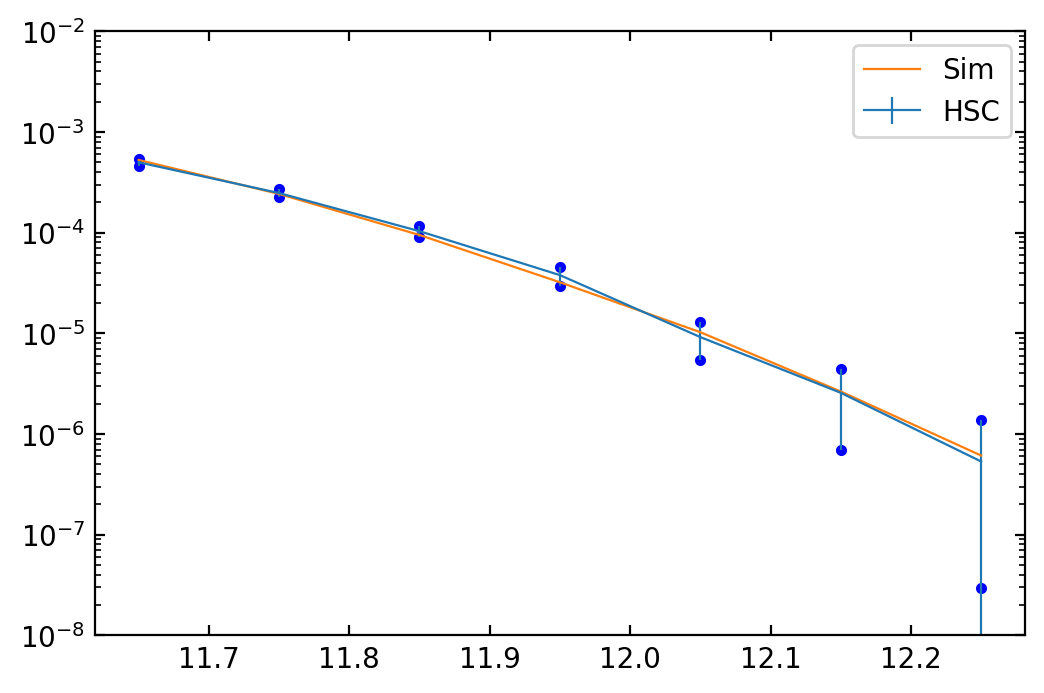

In [13]:
#ax = p.plot_smfs(sim_data, obs_smf, best_p[:5] + np.array([0.06, 0.1, 0.0001, 0.001, -0.4]), best_p[5:] + np.array([0.01, 0]), sim_size, "Vmax@Mpeak")
ax = p.plot_smfs(sim_data, obs_smf, best_fit[:5], best_fit[5:], sim_size, x_field)
ax.set(ylim=(1e-8, 1e-2));

# Compute and Compare Clustering

## In HSC

In [32]:
obs_clust, obs_clust_err = c.compute_hsc_clustering(gals, cen_cuts, sat_cuts, for_plot=True)

Randoms should be much longer that sample: 500000 1565 1708


## In the sim

In [30]:
log_stellar_masses = get_sm_for_sim(sim_data, best_fit[:5], best_fit[5:], x_field)
sim_clust, sim_clust_err  = c.compute_sim_clustering(sim_data, sim_size, log_stellar_masses, cen_cuts, sat_cuts)

Randoms len is 10x the data 734270
10.357619593215858 0.1145818168066679


In [33]:
print(obs_clust, obs_clust_err)
print(sim_clust, sim_clust_err)

18.35111501928993 1.565526745240902
10.357619593215858 0.1145818168066679


## Tests

[None, Text(0.5, 1.0, 'The SMFs are the same (within a scaling factor)')]

/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


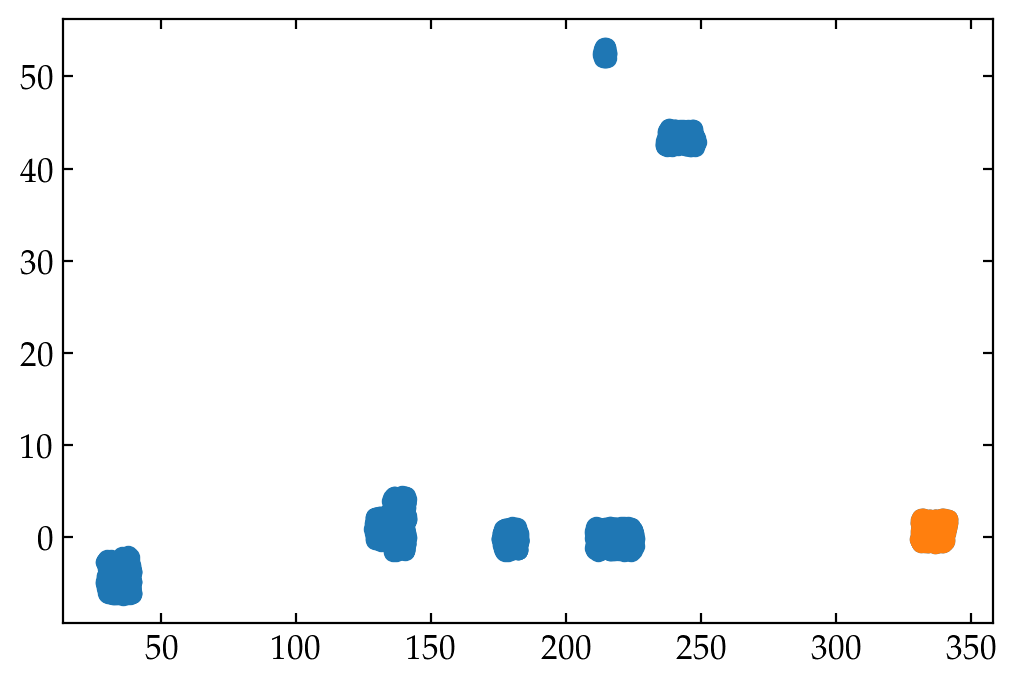

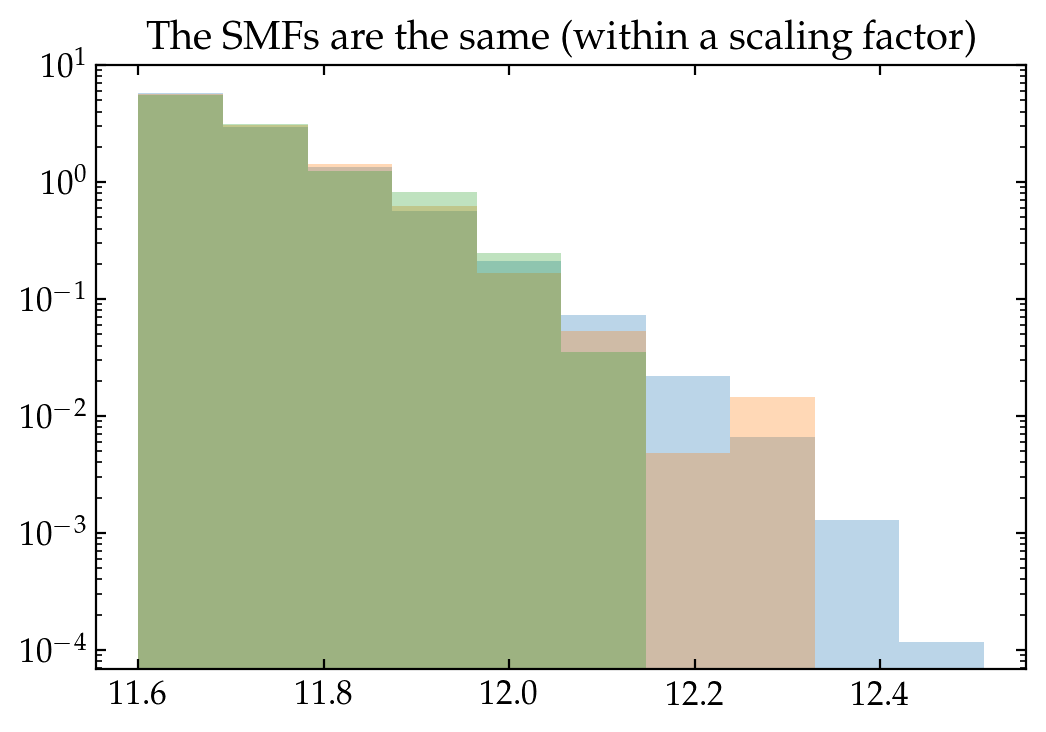

In [21]:
_, ax = plt.subplots()
ax.scatter(gals["ra"], gals["dec"])

ss_gals = gals[gals["ra"] > 300]
ax.scatter(ss_gals["ra"], ss_gals["dec"])

# Are the SMFs the same incl some multiplicative factor?
_, ax = plt.subplots()
_, bins, _ = ax.hist(log_stellar_masses[log_stellar_masses > 11.6], density=True, alpha=0.3)
ax.hist(gals["logm_max"][gals["logm_max"] > 11.6], density=True, bins=bins, alpha=0.3)
ax.hist(ss_gals["logm_max"][ss_gals["logm_max"] > 11.6], density=True, bins=bins, alpha=0.3)
ax.set(yscale="log", title="The SMFs are the same (within a scaling factor)")

No handles with labels found to put in legend.


310
93583
0.25033000111579895 0.4699699878692627
330.88113164799324 341.3245412233512
542.9176576001199 130.05682007678672 36.06198314682097 232.83135321096566 66.82396709626335
5067606.247991663


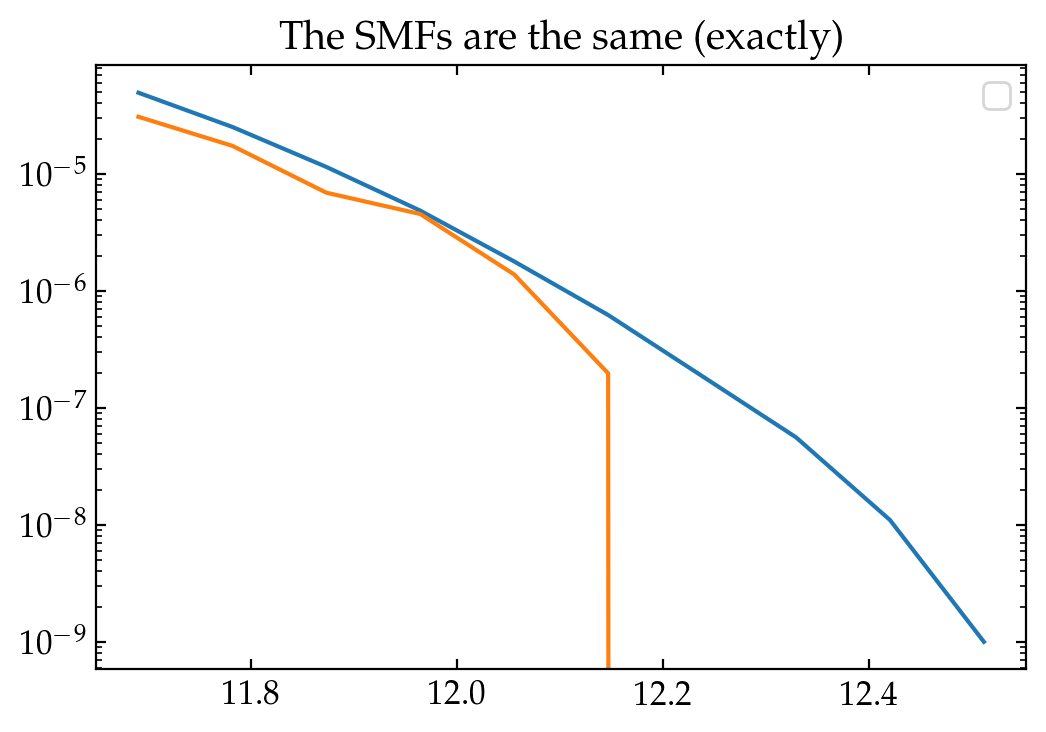

In [22]:
# How about exactly the same (need volume)
print(len(ss_gals[ss_gals["logm_max"] > 11.6]))
print(len(log_stellar_masses[log_stellar_masses > 11.6]))

min_z, max_z = np.min(ss_gals["z_best"]), np.max(ss_gals["z_best"])
min_ra, max_ra = np.min(ss_gals["ra"]), np.max(ss_gals["ra"])
min_dec, max_dec = np.min(ss_gals["dec"]), np.max(ss_gals["dec"])

print(min_z, max_z)
print(min_ra, max_ra)


from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology("planck18")
depth = cosmo.comovingDistance(min_z, max_z)
s_width = cosmo.angularDiameterDistance(min_z * (max_ra - min_ra) / 57)
s_height = cosmo.angularDiameterDistance(min_z * (max_dec - min_dec) / 57)

e_width = cosmo.angularDiameterDistance(max_z * (max_ra - min_ra) / 57)
e_height = cosmo.angularDiameterDistance(max_z * (max_dec - min_dec) / 57)

print(depth, s_width, s_height, e_width, e_height)
vol = depth * (s_width + e_width)/2 * (s_height + e_height)/2
print(vol)

# Are the SMFs the same incl some multiplicative factor?
_, ax = plt.subplots()

count_sim, bins = np.histogram(log_stellar_masses[log_stellar_masses > 11.6])
count_sim =  count_sim / sim_size**3
count_hsc, _ = np.histogram(ss_gals["logm_max"][ss_gals["logm_max"] > 11.6], bins=bins)
count_hsc = count_hsc / vol

ax.plot(bins[:-1] + np.diff(bins)[0], count_sim)
ax.plot(bins[:-1] + np.diff(bins)[0], count_hsc)
ax.set(yscale="log", title="The SMFs are the same (exactly)")
ax.legend()

# Cluster finder